In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 11.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 33.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=178c2b0eeffa6e30df972970559caf5ef306c03f987092cbba9142ad62ba354e
  Stored in directory: /Users/priyathambikumalla/Library/Caches/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark


In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("TitanicKNN").getOrCreate()

# Load data
train_data = spark.read.csv("/Users/priyathambikumalla/Downloads/titanic.csv", header=True, inferSchema=True)

train_data.printSchema()
train_data.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 18:34:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml

# Load the Titanic dataset
titanic = fetch_openml(name='titanic', version=1, as_frame=True)
df = titanic.frame
df

/Users/priyathambikumalla/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3.0,0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [61]:

# Drop rows with missing target values
df = df.dropna(subset=["survived"])
df = df.dropna(subset=["pclass"])
df = df.dropna(subset=["age"])
df = df.dropna(subset=["sibsp"])
df = df.dropna(subset=["parch"])
df = df.dropna(subset=["fare"])
# Select relevant features and label
feature_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X = df[feature_cols]
y = df['survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [62]:

# Write standard scaler from scratch
def custom_standard_scaler(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    scaled_X = (X - mean) / std
    return scaled_X

# Scale the data using the custom standard scaler
X_train_scaled = custom_standard_scaler(X_train)
X_test_scaled = custom_standard_scaler(X_test)


In [63]:
# Determine the K value and create a visualization of the accuracy
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Report the best K value
best_k = k_values[np.argmax(accuracy_scores)]
print(f"The best K value is: {best_k}")

The best K value is: 20


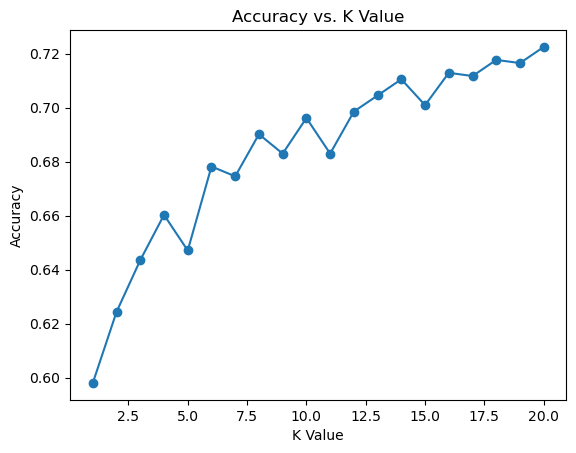

In [64]:
# Create a visualization of the accuracy
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K Value')
plt.show()

In [65]:

import pandas as pd

# Assuming df is your DataFrame
columns_to_fill = ['age', 'fare']

# Replace null values with mean for specific columns
X_train_scaled[columns_to_fill] = X_train_scaled[columns_to_fill].fillna(X_train_scaled[columns_to_fill].mean())

# Display the DataFrame with null values replaced by mean in specified columns
print(X_train_scaled)


X_train_scaled


        pclass       age     sibsp     parch      fare
322  -1.439803  0.448781 -0.564704 -0.497249  1.852363
64   -1.439803 -0.176144  0.530638 -0.497249  0.307657
1220  0.939002  0.171036 -0.564704 -0.497249 -0.535505
728   0.939002  0.934834 -0.564704 -0.497249 -0.535505
1244  0.939002 -0.939942  0.530638  0.657474 -0.526770
...        ...       ...       ...       ...       ...
387  -0.250400  1.282015 -0.564704  1.812196  0.001648
968   0.939002  0.448781  0.530638 -0.497249 -0.395134
910   0.939002 -0.870506 -0.564704 -0.497249 -0.552818
875   0.939002  0.032164 -0.564704 -0.497249 -0.550867
673   0.939002 -0.662197 -0.564704 -0.497249 -0.611072

[836 rows x 5 columns]


,pclass,age,sibsp,parch,fare
322,-1.439803,0.448781,-0.564704,-0.497249,1.852363
64,-1.439803,-0.176144,0.530638,-0.497249,0.307657
1220,0.939002,0.171036,-0.564704,-0.497249,-0.535505
728,0.939002,0.934834,-0.564704,-0.497249,-0.535505
1244,0.939002,-0.939942,0.530638,0.657474,-0.526770
...,...,...,...,...,...
387,-0.250400,1.282015,-0.564704,1.812196,0.001648
968,0.939002,0.448781,0.530638,-0.497249,-0.395134
910,0.939002,-0.870506,-0.564704,-0.497249,-0.552818
875,0.939002,0.032164,-0.564704,-0.497249,-0.550867


In [66]:
# Train the final model with the best K value
final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=20)

In [67]:
# Assuming df is your DataFrame
columns_to_fill = ['age', 'fare']

# Replace null values with mean for specific columns
X_test_scaled[columns_to_fill] = X_test_scaled[columns_to_fill].fillna(X_test_scaled[columns_to_fill].mean())

# Display the DataFrame with null values replaced by mean in specified columns
print(X_test_scaled)


X_test_scaled


        pclass       age     sibsp     parch      fare
1240  0.959794 -2.156350 -0.501321  0.853201 -0.441617
231  -1.414134  1.467381 -0.501321 -0.529117 -0.098158
420  -0.227170 -0.710372  0.601585 -0.529117 -0.395007
729   0.959794  0.273129 -0.501321 -0.529117 -0.451317
281  -1.414134  0.835130  0.601585 -0.529117  0.291521
...        ...       ...       ...       ...       ...
419  -0.227170 -0.710372  0.601585 -0.529117 -0.395007
721   0.959794  0.343379 -0.501321 -0.529117 -0.457567
667   0.959794 -0.288871 -0.501321 -0.529117 -0.451577
1286  0.959794  0.483880 -0.501321 -0.529117 -0.461732
381  -0.227170 -0.078121 -0.501321 -0.529117 -0.371571

[209 rows x 5 columns]


,pclass,age,sibsp,parch,fare
1240,0.959794,-2.156350,-0.501321,0.853201,-0.441617
231,-1.414134,1.467381,-0.501321,-0.529117,-0.098158
420,-0.227170,-0.710372,0.601585,-0.529117,-0.395007
729,0.959794,0.273129,-0.501321,-0.529117,-0.451317
281,-1.414134,0.835130,0.601585,-0.529117,0.291521
...,...,...,...,...,...
419,-0.227170,-0.710372,0.601585,-0.529117,-0.395007
721,0.959794,0.343379,-0.501321,-0.529117,-0.457567
667,0.959794,-0.288871,-0.501321,-0.529117,-0.451577
1286,0.959794,0.483880,-0.501321,-0.529117,-0.461732


In [68]:
# Evaluate using confusion matrix on the test set
y_pred = final_knn_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[102  16]
 [ 40  51]]


In [69]:
from sklearn.metrics import confusion_matrix

# Assuming 'y_true' is the true labels and 'y_pred' is the predicted labels
# y_true = ...
# y_pred = ...

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[102  16]
 [ 40  51]]

Accuracy: 0.7320574162679426


From the above Experiment The Accuracy of the Model is 73 Persent and with the best k value of 20  